# 3. Dimensionality reduction with FastICA

This tutorial reduces the dimensions of the scattering coefficients using the FastICA algorithm based on the concept of an
independent component analysis. We will walk through
the process of extracting the most relevant features in order to use them later
for clustering. We here follow again the indications in Steinmann et al.
([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455))
but we advise that many other methods for reducing the dimensions may be
relevant for other datasets. 

Made in 2022 by René Steinmann and Léonard Seydoux.

> **Note**: This notebook requires the installation of the matplotlib and scikit-learn libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html) and the [scikit-learn website](https://scikit-learn.org/stable/install.html).

In [209]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA,PCA
import umap
import obspy

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for any [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) model (here `FastICA`) of the `scikit-learn` package. The shape of the scattering coefficients are given by the following tuples:

- Order 1: `(n_times, n_channel, octaves[0] * resolution[0])`
- Order 2: `(n_times, n_channel, octaves[0] * octaves[1] * resolution[0]  *
  resolution[1])`
- ...
- Order n: `(n_times, n_channel, np.prod(octaves) * np.prod(resolution))`

We then need to collect the all-order scattering coefficients into a
two-dimensional matrix for the `FastICA` application. 

> Note that the optimal way to load the scattering coefficients is to use `xarray` 

In [210]:
# Load data from file
with np.load("../example/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


## Extract independent features

After loading and stacking the scattering coefficients into a matrix, we can now apply a dimentionality reduction algorithm. We here use the `FastICA` algorithm, but highly recommend to try other algorithms that will allow to proceed in the most adapted way to the data at hand. 

The `FastICA` algorithm performs a matrix factorization with the independent source matrix and the mixing matrix. The `n_components` keyword argument informs the model about how many components (or features, or sources) we want to extract. The residual shape of the `features` matrix will be `(n_times, n_components)` instead of the initial scattering coefficients shape shown above.

In [211]:
# Load features and datetimes from file
with np.load("../example/independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

# Load network
network = pickle.load(open("../example/scattering_network.pickle", "rb"))

In [212]:
umap_model = umap.UMAP(n_components=2,n_neighbors=10)
embedding = umap_model.fit_transform(scattering_coefficients)

/home/steinre/anaconda3/envs/scatseisnet/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


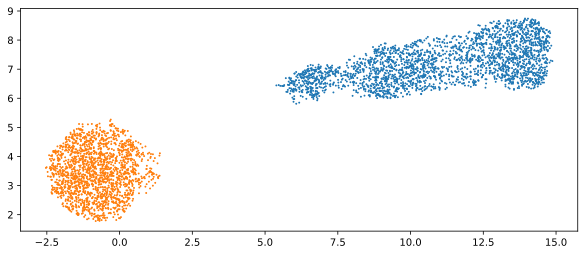

In [216]:
from sklearn.cluster import DBSCAN, KMeans

#cluster_model = DBSCAN(min_samples=50,eps=0.35)
cluster_model = KMeans(n_clusters=2)
predictions = cluster_model.fit_predict(embedding)
#predictions += 1

fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(embedding[where,0],embedding[where,1],s=1)
ax.set_aspect('equal')

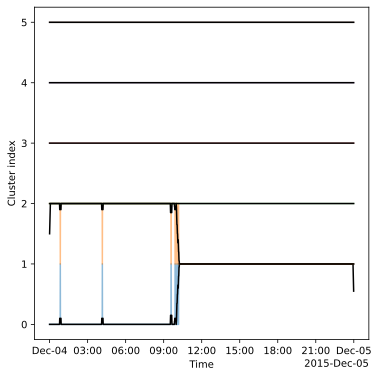

In [217]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

In [218]:
model = PCA(n_components=2, whiten=True)
features = model.fit_transform(scattering_coefficients)

/home/steinre/anaconda3/envs/scatseisnet/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


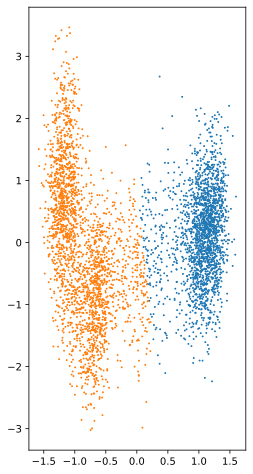

In [222]:
#cluster_model = DBSCAN(min_samples=50,eps=0.15)
cluster_model = KMeans(n_clusters=2)
predictions = cluster_model.fit_predict(features)
#predictions += 1

fig, ax = plt.subplots(figsize=(8,8))
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(features[where,0],features[where,1],s=1)
ax.set_aspect('equal')

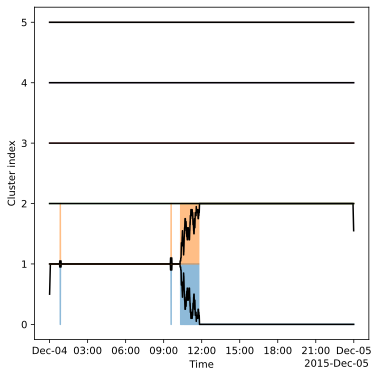

In [223]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

In [191]:
N_WAVEFORMS = 10
N_CLUSTERS = len(np.unique(predictions))
# Read the stream
stream = obspy.read("../example/scattering_stream.mseed").select(channel="HHE")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:N_WAVEFORMS]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        #print(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        trace.filter('highpass',freq=0.9)
        traces.append(trace)
    waveforms.append(traces)

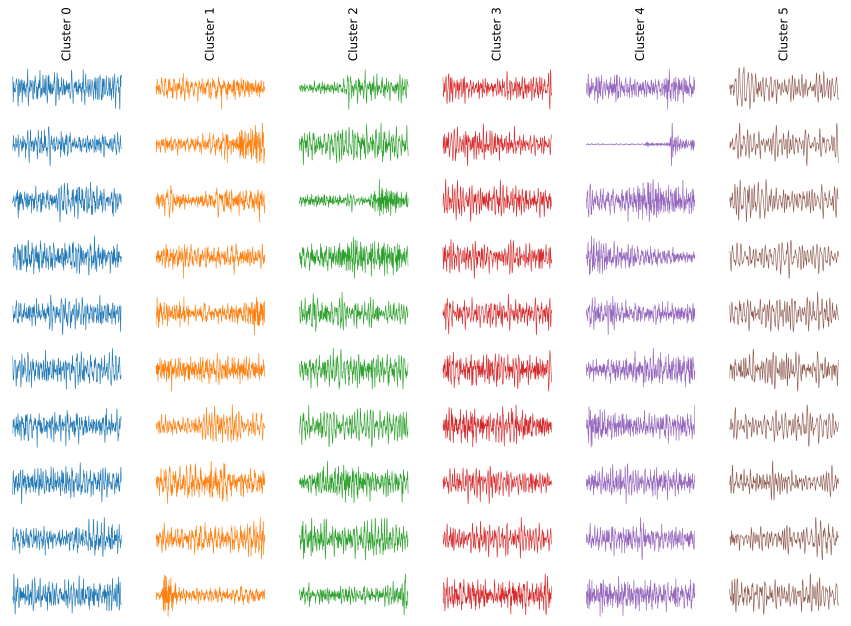

In [192]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300,figsize=(15,10))

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data / np.max(np.abs(trace.data)), rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()

### Save the output

We here save the extracted features as a npz-file, like the scattering coefficients in the previous notebook.

### Have a look at the features

This is a crucial step: do you see structure in the independent components, or do they seem all random? Do the structures correlate with the a priori information at your disposal or to identifiable signal structures? At this stage, it is important to carefully address those questions. The optimal solution may not be to use the `FastICA` model depending on the data at hand, although it can be adapated to many datasets. Playing with the number of components can also be an important way of creating structure in the output.